![Shopping trolley in front of a laptop](./iStock-1249219777.jpg)

It's simple to buy any product with a click and have it delivered to your door. Online shopping has been rapidly evolving over the last few years, making our lives easier. But behind the scenes, e-commerce companies face a complex challenge that needs to be addressed. 

Uncertainty plays a big role in how the supply chains plan and organize their operations to ensure that the products are delivered on time. These uncertainties can lead to challenges such as stockouts, delayed deliveries, and increased operational costs.

You work for the Sales & Operations Planning (S&OP) team at a multinational e-commerce company. They need your help to assist in planning for the upcoming end-of-the-year sales. They want to use your insights to plan for promotional opportunities and manage their inventory. This effort is to ensure they have the right products in stock when needed and ensure their customers are satisfied with the prompt delivery to their doorstep.


## The Data

You are provided with a sales dataset to use. A summary and preview are provided below.

# Online Retail.csv

| Column     | Description              |
|------------|--------------------------|
| `'InvoiceNo'` | A 6-digit number uniquely assigned to each transaction |
| `'StockCode'` | A 5-digit number uniquely assigned to each distinct product |
| `'Description'` | The product name |
| `'Quantity'` | The quantity of each product (item) per transaction |
| `'UnitPrice'` | Product price per unit |
| `'CustomerID'` | A 5-digit number uniquely assigned to each customer |
| `'Country'` | The name of the country where each customer resides |
| `'InvoiceDate'` | The day and time when each transaction was generated `"MM/DD/YYYY"` |
| `'Year'` | The year when each transaction was generated |
| `'Month'` | The month when each transaction was generated |
| `'Week'` | The week when each transaction was generated (`1`-`52`) |
| `'Day'` | The day of the month when each transaction was generated (`1`-`31`) |
| `'DayOfWeek'` | The day of the weeke when each transaction was generated <br>(`0` = Monday, `6` = Sunday) |

# Project Definition: The Data Scientist's View
Before we touch PySpark, let's put on our "S&OP (Sales & Operations Planning) Team" hat.

## 1. The Business Problem
The company is "flying blind" into the most critical sales period of the year (end-of-year sales). This uncertainty means they either:

 - Overstock: Buy too much inventory, which ties up cash and leads to high storage costs and potential clearance markdowns (losing money).

 - Understock: Don't buy enough of a popular item, leading to stockouts. This is a disaster. It means lost sales, angry customers, and damage to the brand's reputation (especially for delayed deliveries).

## 2. The Project Goal (Our Solution)
Our goal is to reduce uncertainty. We will build a demand forecasting model that predicts how much (Quantity) of a specific product (StockCode) will be sold in a specific region (Country) over a future time period (e.g., daily or weekly).

This forecast will directly help the S&OP team make data-driven decisions on:

 - Inventory: "We need to order 5,000 units of StockCode '22423' for the UK warehouse by November 15th."

 - Promotions: "Our model predicts low demand for 'StockCode X' in Germany. Let's plan a 20% off promotion for it."

 - Logistics: "We're expecting a 300% sales spike in the last two weeks of the year. We must increase warehouse staff and delivery capacity."

## 3. The Core Forecasting Challenge
The data we have (Online Retail.csv) is a transaction log. It's a list of every single item in every single order. It is not a time series.

 - Our most critical transformation will be to convert this transaction log into a clean, aggregated time series. For example:

  - Input: 500 rows for StockCode 'ABC' sold in the 'UK' on '2011-05-01'.

  - Output: 1 row: Date: '2011-05-01', StockCode: 'ABC', Country: 'UK', Total_Quantity: 1250, Avg_UnitPrice: 10.99

This aggregated dataset will be the foundation for all our feature engineering and modeling.

# 1.Setup and Data Ingestion

In [1]:
# pip install pyspark

# Uninstall your new PySpark
#%pip uninstall pyspark

# Install an older, Java 11-compatible version
#%pip install pyspark==3.2.4

In [2]:
# Import Required Libraries
from pyspark.sql import SparkSession

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use seaborn style
sns.set_theme(style="whitegrid")

# ML and helper libraries
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler
)
from pyspark.ml.regression import (
    LinearRegression, 
    DecisionTreeRegressor, 
    RandomForestRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator

print("libraries imported successfully.")

libraries imported successfully.


In [3]:
import sys, os
from pyspark.sql import SparkSession

# Make sure Spark uses *this* Python everywhere
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["PATH"] = r"C:\hadoop\bin;" + os.environ["PATH"]

# If a session exists, stop it first
try:
    spark.stop()
except:
    pass

# Create the SparkSession with more memory
# Create the SparkSession
spark = (SparkSession.builder
    .master("local[*]")
    .appName("DemandForecast-Tuned-v2")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.ui.port", "4051")

    # --- BUMPING MEMORY AGAIN ---
    .config("spark.driver.memory", "10g")  # Increased from 8g to 10g
    .config("spark.driver.maxResultSize", "5g")

    .config("spark.executor.memoryOverhead", "1g")
    .getOrCreate())

spark.conf.set("spark.sql.codegen.wholeStage", "false")

print(f"SparkSession created successfully on UI port 4051")
print(f"Spark Version: {spark.version}")

SparkSession created successfully on UI port 4051
Spark Version: 3.2.4


In [6]:
# Define the data file path
file_path = "../data/raw/online_retail.csv"

# Load the dataset
# header=True: Tells Spark the first row is the column names
# inferSchema=True: Tells Spark to automatically guess the data type of each column
df_raw = spark.read.csv(file_path,
                      header=True,
                      inferSchema=True)

In [7]:
# Perform initial data inspection
print("\n--- Data Schema (Column Names and Types) ---")
df_raw.printSchema()


--- Data Schema (Column Names and Types) ---
root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)



In [8]:
print("\n--- First 5 Rows of the Data ---")
# truncate=False shows the full content of columns without cutting them off
df_raw.show(5, truncate=False)


--- First 5 Rows of the Data ---
+---------+---------+-----------------------------------+--------+---------+----------+--------------+-------------------+----+-----+----+---+---------+
|InvoiceNo|StockCode|Description                        |Quantity|UnitPrice|CustomerID|Country       |InvoiceDate        |Year|Month|Week|Day|DayOfWeek|
+---------+---------+-----------------------------------+--------+---------+----------+--------------+-------------------+----+-----+----+---+---------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2.55     |17850     |United Kingdom|2010-01-12 08:26:00|2010|1    |2   |12 |1        |
|536365   |71053    |WHITE METAL LANTERN                |6       |3.39     |17850     |United Kingdom|2010-01-12 08:26:00|2010|1    |2   |12 |1        |
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2.75     |17850     |United Kingdom|2010-01-12 08:26:00|2010|1    |2   |12 |1        |
|536365   |84029G   |KNITTED UNION FLAG HOT WATE

# 2.Data Cleaning & Preprocessing

In [9]:
# Print the starting count of rows
start_count = df_raw.count()
print(f"Original row count: {start_count}")

Original row count: 384721


In [10]:
# Apply all cleaning and preprocessing steps in a single chain
# Remove all transactions with zero or negative quantities
# Remove items that were given away for free
# Drop rows where the Description is null because we can't forecast demand for an unknown product
# Drop rows with a null CustomerID to focus on known customer behavior
# Filter out (~) any row where the InvoiceNo starts with 'C' for cancelled transactions
df_cleaned = df_raw \
    .filter(F.col("Quantity") > 0) \
    .filter(F.col("UnitPrice") > 0) \
    .dropna(subset=["Description", "CustomerID"]) \
    .withColumn("InvoiceNo", F.col("InvoiceNo").cast("string")) \
    .filter(~F.col("InvoiceNo").startswith("C"))

In [11]:
# Print the final count of rows after cleaning
end_count = df_cleaned.count()
print(f"Cleaned row count: {end_count}")
print(f"Rows removed: {start_count - end_count}")

Cleaned row count: 384721
Rows removed: 0


In [12]:
# Let's check the new min/max values for Quantity and UnitPrice
print("\n--- Statistical Summary of Cleaned Data ---")
df_cleaned.select("Quantity", "UnitPrice").describe().show()


--- Statistical Summary of Cleaned Data ---
+-------+-----------------+------------------+
|summary|         Quantity|         UnitPrice|
+-------+-----------------+------------------+
|  count|           384721|            384721|
|   mean|8.306411659358341|2.9109200953413783|
| stddev|9.301335531853901| 4.187107266433148|
|    min|                1|               0.1|
|    max|               54|             649.5|
+-------+-----------------+------------------+



# 3.Feature Engineering & Aggregation

In [13]:
# Create Time Features & Aggregate to Daily Panel
# Use one chained operation for efficiency
# Create the 'Date' column *first*, then group by it.

print("Starting aggregation from transactional data...")
df_aggregated = df_cleaned \
    .withColumn("Date", F.to_date(F.col("InvoiceDate"))) \
    .groupBy("Date", "StockCode", "Country") \
    .agg(
        # This is our target variable (the "answer")
        F.sum("Quantity").alias("TotalQuantity"),
        
        # These are "intermediate" features. We will NOT
        # feed these directly to the model. We will only feed
        # the *lagged versions* of them.
        F.avg("UnitPrice").alias("AvgPrice"),
        F.countDistinct("InvoiceNo").alias("NumTransactions"),
        F.avg("Quantity").alias("AvgQtyPerTransaction")
    )

print("Aggregation complete.")

Starting aggregation from transactional data...
Aggregation complete.


In [14]:
# Create Calendar Features 
# Add features that describe the *day*
# Calendar features are always "known in advance"
print("Adding calendar features...")
df_with_calendar = df_aggregated \
    .withColumn("DayOfWeek", F.dayofweek(F.col("Date"))) \
    .withColumn("DayOfMonth", F.dayofmonth(F.col("Date"))) \
    .withColumn("WeekOfYear", F.weekofyear(F.col("Date"))) \
    .withColumn("Month", F.month(F.col("Date"))) \
    .withColumn("Quarter", F.quarter(F.col("Date"))) \
    .withColumn("Year", F.year(F.col("Date"))) \
    .withColumn("IsWeekend", F.when(F.dayofweek(F.col("Date")).isin([1, 7]), 1).otherwise(0)) \
    .withColumn("IsMonthStart", F.when(F.dayofmonth(F.col("Date")) == 1, 1).otherwise(0)) \
    .withColumn("IsMonthEnd", F.when(F.dayofmonth(F.col("Date")) == F.dayofmonth(F.last_day(F.col("Date"))), 1).otherwise(0))

print("Calendar features added.")

Adding calendar features...
Calendar features added.


In [15]:
# Create Lag, Rolling & Price Features

print("Defining window specifications...")
# This is our "key" for all window functions.
# We want to calculate features *per item* and *per country*, ordered by date.
base_window_spec = Window.partitionBy("StockCode", "Country").orderBy("Date")

# Window spec for 7-day rolling features (i.e., last 7 sales days)
window_roll_7d = base_window_spec.rowsBetween(-6, Window.currentRow)

# Window spec for 30-day rolling features (i.e., last 30 sales days)
window_roll_30d = base_window_spec.rowsBetween(-29, Window.currentRow)

# Features represent what the model actually knows (i.e., "what was the average price yesterday?")
print("Adding lag and rolling features...")
df_features = df_with_calendar \
    .withColumn("TotalQuantity_lag_1", F.lag("TotalQuantity", 1).over(base_window_spec)) \
    .withColumn("TotalQuantity_lag_7", F.lag("TotalQuantity", 7).over(base_window_spec)) \
    .withColumn("TotalQuantity_lag_30", F.lag("TotalQuantity", 30).over(base_window_spec)) \
    .withColumn("Qty_moving_avg_7", F.avg("TotalQuantity").over(window_roll_7d)) \
    .withColumn("Qty_moving_avg_30", F.avg("TotalQuantity").over(window_roll_30d)) \
    .withColumn("Qty_volatility_7", F.stddev("TotalQuantity").over(window_roll_7d)) \
    .withColumn("AvgPrice_lag_1", F.lag("AvgPrice", 1).over(base_window_spec)) \
    .withColumn("NumTransactions_lag_1", F.lag("NumTransactions", 1).over(base_window_spec)) \
    .withColumn("AvgQtyPerTransaction_lag_1", F.lag("AvgQtyPerTransaction", 1).over(base_window_spec))


# Create Price Change Feature & Fill Nulls
# We calculate price change and fill all nulls created by the window functions.
# (Window functions can't calculate a lag or rolling avg for the first few rows)
print("Calculating final features and cleaning up...")
df_final_features = df_features \
    .withColumn("Price_change_pct_lag_1", 
        (F.col("AvgPrice_lag_1") - F.lag("AvgPrice_lag_1", 1).over(base_window_spec)) 
        / F.lag("AvgPrice_lag_1", 1).over(base_window_spec)
    ) \
    .drop("AvgPrice", "NumTransactions", "AvgQtyPerTransaction") \
    .na.fill(0) # Fill all nulls created by lags/rolling windows

print("Feature Engineering complete!")

Defining window specifications...
Adding lag and rolling features...
Calculating final features and cleaning up...
Feature Engineering complete!


In [16]:
# Verification
print("\n--- Schema of Final Features DataFrame ---")
df_final_features.printSchema()


--- Schema of Final Features DataFrame ---
root
 |-- Date: date (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalQuantity: long (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IsWeekend: integer (nullable = false)
 |-- IsMonthStart: integer (nullable = false)
 |-- IsMonthEnd: integer (nullable = false)
 |-- TotalQuantity_lag_1: long (nullable = true)
 |-- TotalQuantity_lag_7: long (nullable = true)
 |-- TotalQuantity_lag_30: long (nullable = true)
 |-- Qty_moving_avg_7: double (nullable = false)
 |-- Qty_moving_avg_30: double (nullable = false)
 |-- Qty_volatility_7: double (nullable = false)
 |-- AvgPrice_lag_1: double (nullable = false)
 |-- NumTransactions_lag_1: long (nullable = true)
 |-- AvgQtyPerTransactio

In [17]:
print("\n--- Sample of Final Features DataFrame ---")
# Show a sample, ordered by Date, to see the features in action
df_final_features.orderBy("Date", ascending=False).show(5, truncate=False)


--- Sample of Final Features DataFrame ---
+----------+---------+--------------+-------------+---------+----------+----------+-----+-------+----+---------+------------+----------+-------------------+-------------------+--------------------+------------------+------------------+------------------+--------------+---------------------+--------------------------+----------------------+
|Date      |StockCode|Country       |TotalQuantity|DayOfWeek|DayOfMonth|WeekOfYear|Month|Quarter|Year|IsWeekend|IsMonthStart|IsMonthEnd|TotalQuantity_lag_1|TotalQuantity_lag_7|TotalQuantity_lag_30|Qty_moving_avg_7  |Qty_moving_avg_30 |Qty_volatility_7  |AvgPrice_lag_1|NumTransactions_lag_1|AvgQtyPerTransaction_lag_1|Price_change_pct_lag_1|
+----------+---------+--------------+-------------+---------+----------+----------+-----+-------+----+---------+------------+----------+-------------------+-------------------+--------------------+------------------+------------------+------------------+--------------+---

# 4.Exploratory Data Analysis (EDA)

In [18]:
# Register the DataFrame as a Temporary SQL View
# This allows us to run SQL queries on our 'df_final_features' DataFrame.
df_final_features.createOrReplaceTempView("sales")

print("Temporary view 'sales' created successfully.")

Temporary view 'sales' created successfully.


Generating plot for: Top 10 Products


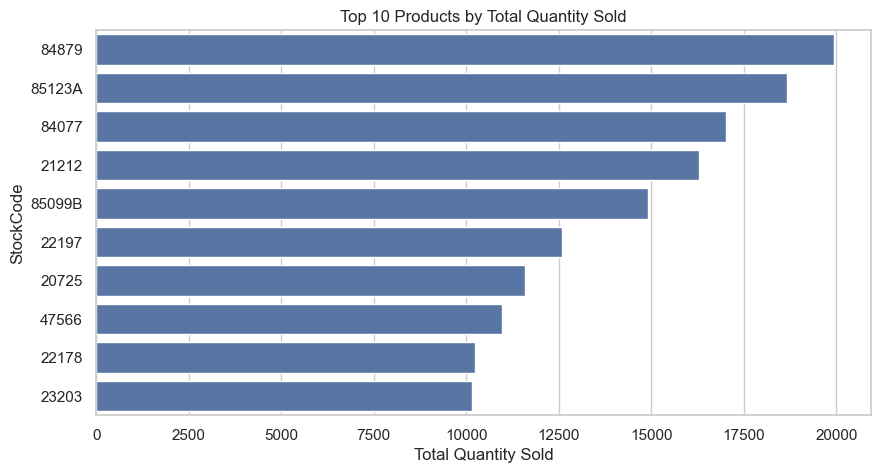

In [19]:
# Run SQL Queries for Analysis ---

# --- 1. Top 10 Products by Total Quantity Sold ---
print("Generating plot for: Top 10 Products")

# Run the query and convert to Pandas
top_products_df = spark.sql("""
    SELECT 
        StockCode, 
        SUM(TotalQuantity) AS TotalSales
    FROM sales
    GROUP BY StockCode
    ORDER BY TotalSales DESC
    LIMIT 10
""").toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='TotalSales', y='StockCode', data=top_products_df, orient='h')
plt.title('Top 10 Products by Total Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('StockCode')
plt.show()

Generating plot for: Top 10 Countries by True Total Revenue


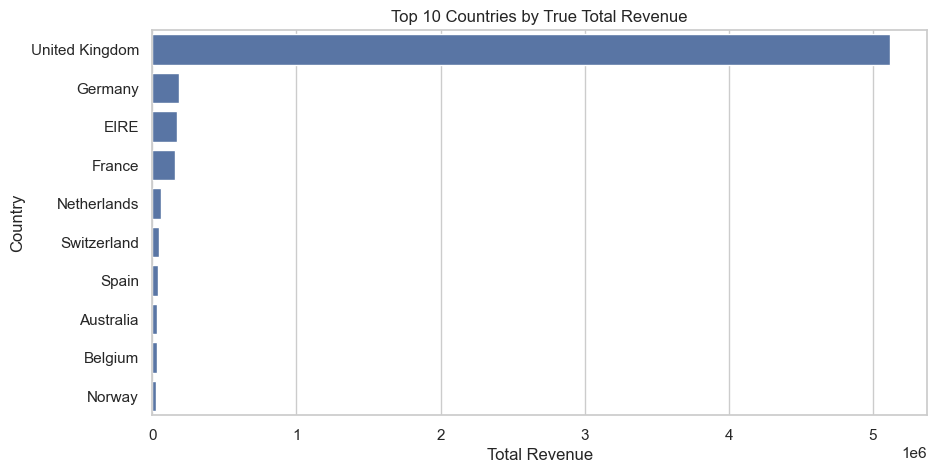

In [20]:
# --- 2. Top 10 Countries by Revenue ---
print("Generating plot for: Top 10 Countries by True Total Revenue")

# 1. Start from df_cleaned (our clean transactional data)
# 2. Calculate "Revenue" for each *individual transaction*
# 3. Group by Country and Sum the revenue
top_countries_df = df_cleaned \
    .withColumn("Revenue", F.col("Quantity") * F.col("UnitPrice")) \
    .groupBy("Country") \
    .agg(F.sum("Revenue").alias("TotalRevenue")) \
    .orderBy(F.col("TotalRevenue").desc()) \
    .limit(10)

# Convert the small, aggregated result to Pandas
pd_top_countries = top_countries_df.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='TotalRevenue', y='Country', data=pd_top_countries, orient='h')
plt.title('Top 10 Countries by True Total Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.show()

Generating plot for: Weekly Sales Seasonality


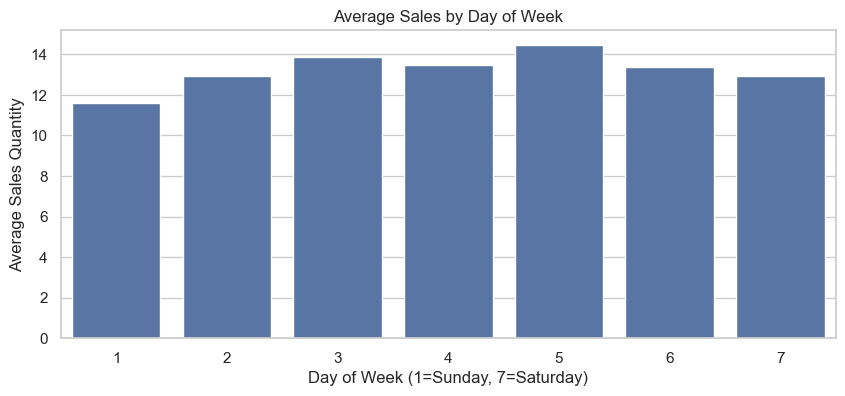

In [21]:
# --- 3. Weekly Sales Seasonality ---
print("Generating plot for: Weekly Sales Seasonality")

# Run the query and convert to Pandas
weekly_sales_df = spark.sql("""
    SELECT 
        DayOfWeek,
        AVG(TotalQuantity) AS AverageSales
    FROM sales
    GROUP BY DayOfWeek
    ORDER BY DayOfWeek
""").toPandas()

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x='DayOfWeek', y='AverageSales', data=weekly_sales_df)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week (1=Sunday, 7=Saturday)')
plt.ylabel('Average Sales Quantity')
plt.show()

Generating plot for: Monthly Sales Seasonality


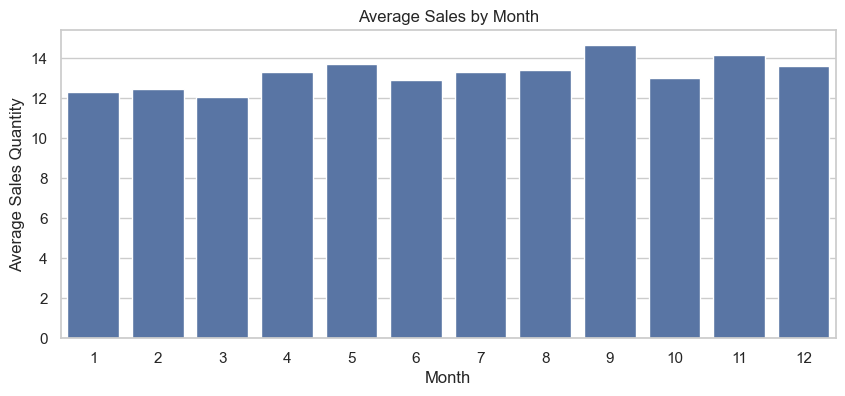

In [22]:
# --- 4. Monthly Sales Seasonality ---
print("Generating plot for: Monthly Sales Seasonality")

# Run the query and convert to Pandas
monthly_sales_df = spark.sql("""
    SELECT 
        Month,
        AVG(TotalQuantity) AS AverageSales
    FROM sales
    GROUP BY Month
    ORDER BY Month
""").toPandas()

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Month', y='AverageSales', data=monthly_sales_df)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales Quantity')
plt.show()

In [23]:
# --- 5. Price Elasticity Hint (No plot needed) ---
print("Result for: Price Elasticity using lagged price")

# The correlation is just a single number, so we'll just run the query and show it.
# No plot is necessary.
spark.sql("""
    SELECT 
        CORR(AvgPrice_lag_1, TotalQuantity) AS LaggedPriceElasticity
    FROM sales
    WHERE AvgPrice_lag_1 > 0 
""").show()

print("\nEDA visualizations are complete.")

Result for: Price Elasticity using lagged price
+---------------------+
|LaggedPriceElasticity|
+---------------------+
| -0.16165465655459044|
+---------------------+


EDA visualizations are complete.


In [24]:
print("\n--- NEW: Correlation with Yesterday's Sales ---")
# Let's see how strongly today's sales are correlated with yesterday's.
# This should be a very strong, positive number.
spark.sql("""
    SELECT 
        CORR(TotalQuantity_lag_1, TotalQuantity) AS Lag1_Correlation
    FROM sales
""").show()


--- NEW: Correlation with Yesterday's Sales ---
+------------------+
|  Lag1_Correlation|
+------------------+
|0.3740227155441219|
+------------------+



# 5.Model Building & Evaluation

In [25]:
# Feature Assembly Setup

# First, rename our target column 'TotalQuantity' to 'label'
# This is the default name PySpark ML looks for
df_ml_data = df_final_features.withColumnRenamed("TotalQuantity", "label")

# Define our categorical columns that need indexing/encoding
#categorical_cols = ["StockCode", "Country"]
categorical_cols_index = ["StockCode"] # <-- Just Index this
categorical_cols_ohe = ["Country"]   # <-- Index AND One-Hot Encode this

# Define our numerical feature columns
# This is every feature we built, *except* the target and identifying columns
numerical_cols = [
    # Calendar Features (Safe)
    "DayOfWeek",
    "DayOfMonth",
    "WeekOfYear",
    "Month",
    "Quarter",
    "Year",
    "IsWeekend",
    "IsMonthStart",
    "IsMonthEnd",
    
    # Lag Features (Safe - all from the past)
    "TotalQuantity_lag_1",
    "TotalQuantity_lag_7",
    "TotalQuantity_lag_30",
    "AvgPrice_lag_1",
    "NumTransactions_lag_1",
    "AvgQtyPerTransaction_lag_1",
    "Price_change_pct_lag_1",

    # Rolling Features (Safe - all from the past)
    "Qty_moving_avg_7",
    "Qty_moving_avg_30",
    "Qty_volatility_7"
]    

print(f"Using {len(numerical_cols)} non-leaking features.")

Using 19 non-leaking features.


In [26]:
# Create the Preprocessing Pipeline ---

print("Building feature engineering pipeline...")

# Stage 1: Create StringIndexer stages for each categorical column
# We use a loop to keep it simple and clean
indexers = [
    StringIndexer(
        inputCol=col, 
        outputCol=f"{col}_idx", 
        handleInvalid="keep"
    ) for col in (categorical_cols_index + categorical_cols_ohe)
]

# Stage 2: Create OneHotEncoder stages for the indexed columns
encoders = [
    OneHotEncoder(
        inputCol=f"{col}_idx", 
        outputCol=f"{col}_ohe"
    ) for col in categorical_cols_ohe
]

# Stage 3: Create VectorAssembler
# This combines all numerical and encoded categorical features into one vector
ohe_output_cols = [f"{col}_ohe" for col in categorical_cols_ohe]
idx_output_cols = [f"{col}_idx" for col in categorical_cols_index]
all_feature_cols = numerical_cols + idx_output_cols + ohe_output_cols

assembler = VectorAssembler(
    inputCols=all_feature_cols, 
    outputCol="features"
)

# Combine all stages into a single preprocessing pipeline
# We will fit this pipeline on our *training data only*
preprocess_pipeline = Pipeline(stages = indexers + encoders + [assembler])

Building feature engineering pipeline...


In [27]:
# Train/Test Split (Time-Based) ---
# This is the most important part of a forecasting project!
split_date = "2011-09-25"

train_df = df_ml_data.filter(F.col("Date") <= split_date)
test_df = df_ml_data.filter(F.col("Date") > split_date)

# Cache the dataframes for faster access during ML
train_df.cache()
test_df.cache()

print(f"Training data: {train_df.count()} rows (before {split_date})")
print(f"Test data: {test_df.count()} rows (after {split_date})")

Training data: 175452 rows (before 2011-09-25)
Test data: 64524 rows (after 2011-09-25)


In [28]:
# --- Fit the Preprocessing Pipeline ---
# We fit the pipeline (indexers, etc.) *only* on the training data
print("\nFitting preprocessing pipeline on training data...")
preprocess_model = preprocess_pipeline.fit(train_df)


Fitting preprocessing pipeline on training data...


In [29]:
# Transform both train and test data using the *fitted* pipeline
print("Transforming train and test data...")
train_processed_df = preprocess_model.transform(train_df)
test_processed_df = preprocess_model.transform(test_df)

Transforming train and test data...


In [30]:
# --- THIS IS THE NEW LINE ---
print("Caching processed training data...")
train_processed_df.cache()
# This forces Spark to do all the feature engineering *now*
# and hold the results in memory, which makes 'fit' much more stable.
# -----------------------------

Caching processed training data...


DataFrame[Date: date, StockCode: string, Country: string, label: bigint, DayOfWeek: int, DayOfMonth: int, WeekOfYear: int, Month: int, Quarter: int, Year: int, IsWeekend: int, IsMonthStart: int, IsMonthEnd: int, TotalQuantity_lag_1: bigint, TotalQuantity_lag_7: bigint, TotalQuantity_lag_30: bigint, Qty_moving_avg_7: double, Qty_moving_avg_30: double, Qty_volatility_7: double, AvgPrice_lag_1: double, NumTransactions_lag_1: bigint, AvgQtyPerTransaction_lag_1: double, Price_change_pct_lag_1: double, StockCode_idx: double, Country_idx: double, Country_ohe: vector, features: vector]

In [31]:
# Select & Train Models ---

print("\n--- Training Models ---")

# 1. Linear Regression (Baseline)
#print("Training Linear Regression...")
#lr = LinearRegression(featuresCol="features", labelCol="label")
#lr_model = lr.fit(train_processed_df)

# 2. Decision Tree
print("Training Decision Tree...")
dt = DecisionTreeRegressor(featuresCol="features",
                           labelCol="label",
                           maxBins=3700) # <-- ADD THIS LINE

dt_model = dt.fit(train_processed_df)
print("Decision Tree trained.")

# 3. Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(featuresCol="features",
                           labelCol="label",
                           numTrees=50,
                           maxDepth=8,
                           maxBins=3700) # <-- ADD THIS LINE

rf_model = rf.fit(train_processed_df)
print("Random Forest trained.")

print("All models trained successfully.")


--- Training Models ---
Training Decision Tree...
Decision Tree trained.
Training Random Forest...
Random Forest trained.
All models trained successfully.


In [32]:
# Evaluate Models ---

print("\n--- Model Evaluation on Test Data ---")

# Get predictions for each model
#lr_preds = lr_model.transform(test_processed_df)
dt_preds = dt_model.transform(test_processed_df)
rf_preds = rf_model.transform(test_processed_df)

# Create our evaluators
eval_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
eval_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
eval_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2") 

# Helper function to calculate MAPE (Mean Absolute Percentage Error)
# We do this one manually as per the plan
def calculate_mape(predictions_df):
    # Filter out rows where the actual value is 0 to avoid divide-by-zero
    mape_df = predictions_df.filter(F.col("label") != 0)
    
    # Calculate Absolute Percentage Error
    mape_df = mape_df.withColumn(
        "APE", 
        F.abs((F.col("label") - F.col("prediction")) / F.col("label"))
    )
    
    # Calculate Mean APE and return as a percentage
    mape_result = mape_df.select(F.mean("APE")).first()
    if mape_result and mape_result[0]:
        return mape_result[0] * 100
    return float('inf') # Return infinity if something went wrong

# Evaluate Linear Regression
#lr_rmse = eval_rmse.evaluate(lr_preds)
#lr_mae = eval_mae.evaluate(lr_preds)
#lr_r2 = eval_r2.evaluate(lr_preds)
#lr_mape = calculate_mape(lr_preds)

# Evaluate Decision Tree
dt_rmse = eval_rmse.evaluate(dt_preds)
dt_mae = eval_mae.evaluate(dt_preds)
dt_r2 = eval_r2.evaluate(dt_preds)
dt_mape = calculate_mape(dt_preds)

# Evaluate Random Forest
rf_rmse = eval_rmse.evaluate(rf_preds)
rf_mae = eval_mae.evaluate(rf_preds)
rf_r2 = eval_r2.evaluate(rf_preds)
rf_mape = calculate_mape(rf_preds)


--- Model Evaluation on Test Data ---


In [33]:
# --- Final Results ---
print("\n--- Updated Model Comparison ---")
print("| Model               | RMSE     | MAE      | MAPE (%) | R-squared |")
print("|---------------------|----------|----------|----------|-----------|")
#print(f"| Linear Regression   | {lr_rmse:<8.2f} | {lr_mae:<8.2f} | {lr_mape:<8.2f} | {lr_r2:<9.2f} |")
print(f"| Decision Tree       | {dt_rmse:<8.2f} | {dt_mae:<8.2f} | {dt_mape:<8.2f} | {dt_r2:<9.2f} |")
print(f"| Random Forest       | {rf_rmse:<8.2f} | {rf_mae:<8.2f} | {rf_mape:<8.2f} | {rf_r2:<9.2f} |")

# Clean up cache
train_df.unpersist()
test_df.unpersist()


--- Updated Model Comparison ---
| Model               | RMSE     | MAE      | MAPE (%) | R-squared |
|---------------------|----------|----------|----------|-----------|
| Decision Tree       | 13.34    | 7.88     | 154.06   | 0.45      |
| Random Forest       | 13.01    | 7.94     | 169.83   | 0.48      |


DataFrame[Date: date, StockCode: string, Country: string, label: bigint, DayOfWeek: int, DayOfMonth: int, WeekOfYear: int, Month: int, Quarter: int, Year: int, IsWeekend: int, IsMonthStart: int, IsMonthEnd: int, TotalQuantity_lag_1: bigint, TotalQuantity_lag_7: bigint, TotalQuantity_lag_30: bigint, Qty_moving_avg_7: double, Qty_moving_avg_30: double, Qty_volatility_7: double, AvgPrice_lag_1: double, NumTransactions_lag_1: bigint, AvgQtyPerTransaction_lag_1: double, Price_change_pct_lag_1: double]

# Insights, Visualization & Showcase

In [34]:
# --- 1. Final Visualization: Actual vs. Predicted ---

# We need to pick one product in one country to visualize.
# Let's pick a popular one: StockCode '85123A' in the 'United Kingdom'.
# You can change these values to explore other items.
SAMPLE_STOCKCODE = '85123A'
SAMPLE_COUNTRY = 'United Kingdom'

print(f"\nFetching predictions for {SAMPLE_STOCKCODE} in {SAMPLE_COUNTRY}...")

# Filter our test set predictions for this specific item
sample_preds_df = rf_preds \
    .filter((F.col("StockCode") == SAMPLE_STOCKCODE) & (F.col("Country") == SAMPLE_COUNTRY)) \
    .select("Date", "label", "prediction") \
    .orderBy("Date")

# Convert the (now small) Spark DataFrame to a Pandas DataFrame for plotting
pd_sample_preds = sample_preds_df.toPandas()


Fetching predictions for 85123A in United Kingdom...


Plotting Actual vs. Predicted sales...


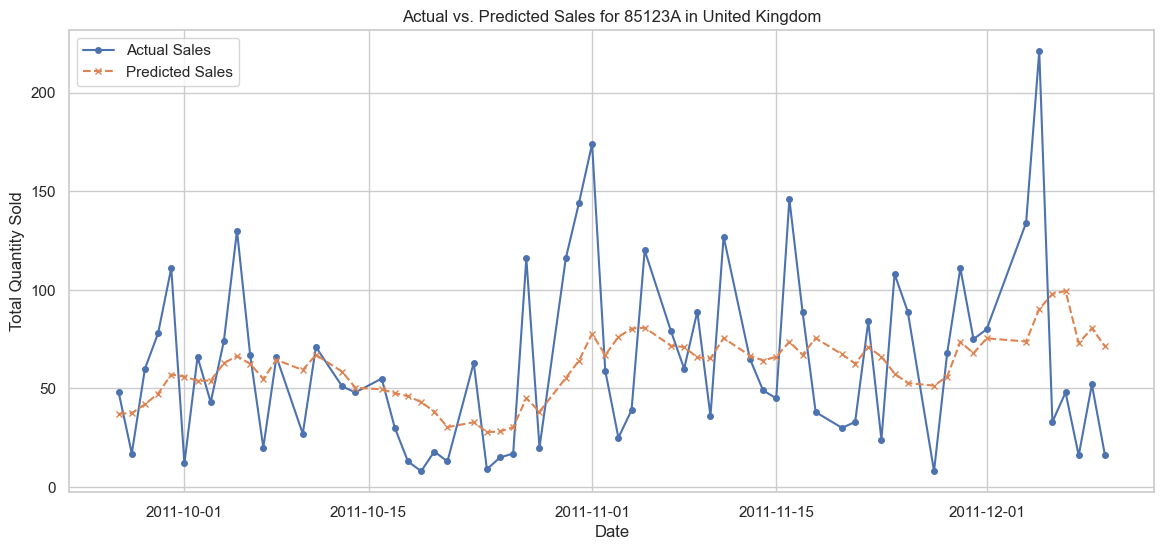

In [35]:
print("Plotting Actual vs. Predicted sales...")

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(pd_sample_preds['Date'], pd_sample_preds['label'], label='Actual Sales', marker='o', markersize=4)
plt.plot(pd_sample_preds['Date'], pd_sample_preds['prediction'], label='Predicted Sales', linestyle='--', marker='x', markersize=4)
plt.title(f'Actual vs. Predicted Sales for {SAMPLE_STOCKCODE} in {SAMPLE_COUNTRY}')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


Extracting and plotting feature importances from *Random Forest*...


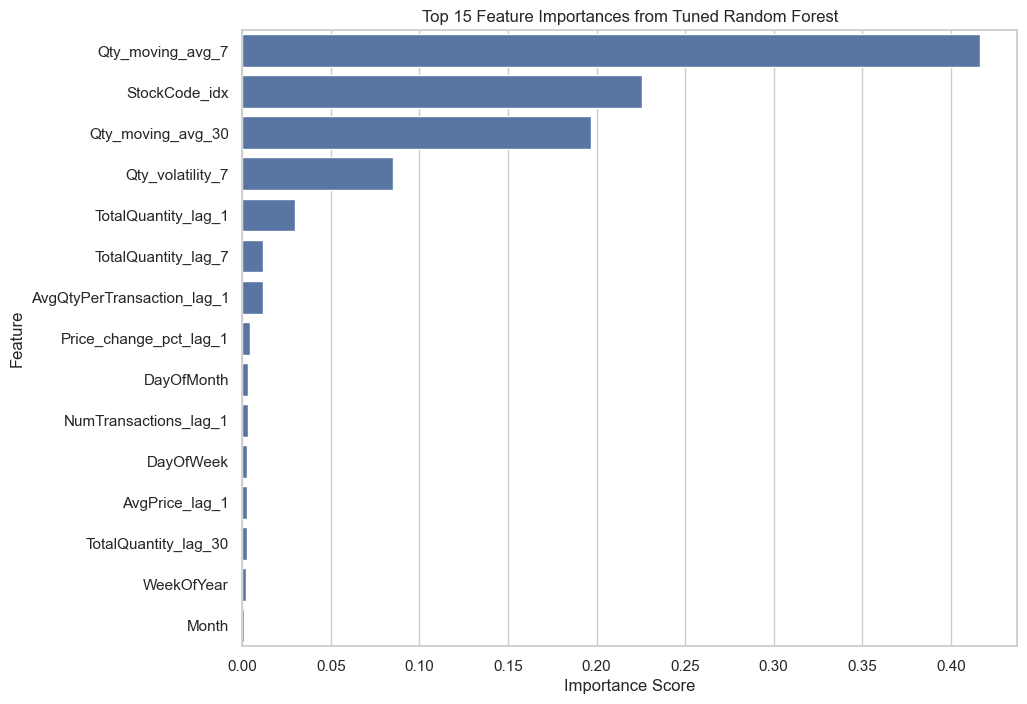

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("\nExtracting and plotting feature importances from *Random Forest*...")

# --- Make sure this is your trained Random Forest model ---
importances = rf_model.featureImportances

# Get the list of feature names from our *fitted* preprocessing pipeline
# (This code is the same as before)
assembler_stage = preprocess_model.stages[-1]
feature_names = assembler_stage.getInputCols()

# Create a Pandas DataFrame
feature_imp_df = pd.DataFrame(
    list(zip(feature_names, importances.toArray())),
    columns=['Feature', 'Importance']
)

# Sort by importance and take the Top 15 features
top_features_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Plot the Top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features_df, orient='h')
plt.title('Top 15 Feature Importances from Tuned Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [37]:
from pyspark.sql import functions as F

# 1. Get Predictions for the *Entire* Test Set
# (This step might already be done from your model evaluation)
print("Generating all test predictions...")
all_test_preds_df = rf_model.transform(test_processed_df)

# 2. Filter for Week 39 of 2011
print("Filtering for Week 39...")
df_w39 = all_test_preds_df.filter(
    (F.col("WeekOfYear") == 39) & (F.col("Year") == 2011)
)

# 3. Sum the 'prediction' column to get the total
# .agg() returns a small DataFrame
total_sales_df = df_w39.agg(F.sum("prediction").alias("total_sales"))

# 4. Extract the number from the DataFrame
# .first() gets the first (and only) Row
# ["total_sales"] gets the value from that row
total_sales_value = total_sales_df.first()["total_sales"]

# 5. Store as an integer variable as requested
quantity_sold_w39 = int(total_sales_value)

print(f"\nTotal expected units to be sold in Week 39 of 2011: {quantity_sold_w39}")

Generating all test predictions...
Filtering for Week 39...

Total expected units to be sold in Week 39 of 2011: 97502
